# Softmax Çıktıları ve -Adversarial Attack-

Bu notebookta modelin `softmax` çıktılarını inceleyeceğiz. `Softmax` çıktıları modelin bir tahminden ne kadar emin olup olmadığını bize söylemez.
* **Örnek**: Modelin bir sınıf için `softmax` çıktısı 0.99 ise, model bu tahminden %99 emin diyemeyiz. 
 
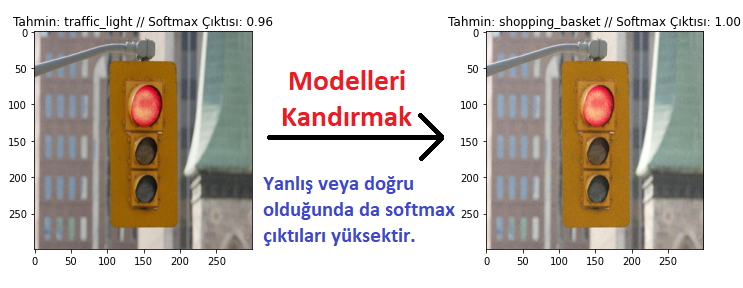

<br>  
  
`Softmax` değerleri aslında normalize edilmiş değerlerdir. 0 ve 1 arasında oldukları için olasılıkmış gibi yorumlayabiliriz fakat bu bize modelin tahminden ne kadar emin olup olmadığını göstermez.

<br>

**Soru:** Modelin tahminden emin olduğunu anlamak için ne yapmalıyız peki?

**Cevap:** Bir yöntem olarak Bayesian Deep Learning kullanabiliriz. İlerleyen zamanlarda örneklerini yüklemeyi düşünüyorum.
  
<br>

Şimdi ise bu notebookta Deep Learning modellerinin aslında ne kadar kolay kandırılabileceğini göstereceğim.

<br>

## İçerikler
**fashion_mnist Verisetini Yükleyip Hazırlamak**
  * tf.one_hot()
  * tf.cast()
  * prefetch()
  
**Basit Bir CNN Yazmak**
  * Conv2D()
  * MaxPooling2D()

**Resimlere Basit Noise Ekleyip Tahmin Almak**
  * Noise ve Etkilenen Softmax Çıktıları

**InceptionResNetV2'de Aynı Noise Yaklaşımını Test Etmek**
  * 55M Parametresi Olan InceptionResNetV2
  * Noise ve InceptionResNetV2

**tf.GradientTape**
  * tape.watch()
  * optimizer.apply_gradients()

**InceptionResNetV2'ye Adversarial Attack**
  * Özel Bir Noise Vektörü Oluşturmak
  * Sonucu Görselleştirmek

## Kütüphaneler

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions

import tensorflow_datasets as tfds

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

tf.__version__

'2.7.0'

## TFDS ile Fashion MNIST Yükleme
* `fashion_mnist` verisetini yükleyip hazırlayacağız. Bu notebook'un asıl hedefi modelleri kandırmak olduğu için burayı kısa geçiyorum.

In [2]:
train_ds, test_ds = tfds.load('fashion_mnist', split = ['train', 'test'],
                             as_supervised = True)

train_ds = train_ds.batch(128).map(lambda x, y: (tf.cast(x / 255, tf.float32),
                                                tf.one_hot(y, 10))).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(128).map(lambda x, y: (tf.cast(x / 255, tf.float32),
                                                tf.one_hot(y, 10))).prefetch(tf.data.AUTOTUNE)

## Basit Bir Model Yazalım
* 3 convolution, 2 pooling içeren bir model yazalım.

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation = 'swish', input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(32, 3, activation = 'swish'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation = 'swish'),
    
    tf.keras.layers.GlobalMaxPooling2D(),
    
    tf.keras.layers.Dense(128, activation = 'swish'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
             metrics = ['acc'])

model.summary()

model.fit(train_ds, epochs = 16, validation_data = test_ds)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0

Random gürültü vektörlerinde bile softmax çıktıları bir sınıf için yüksek olacaktır.

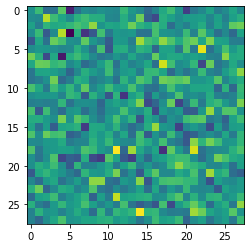

In [4]:
random_noise = tf.random.normal(stddev = 0.5, mean = 0.1, shape = (28, 28, 1))
plt.imshow(tf.squeeze(random_noise))

Her sınıfa %10 değer vermesini bekleyebiliriz ama kesinlikle öyle olmayacak.

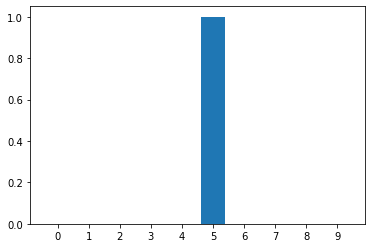

In [5]:
random_predict = model.predict(tf.expand_dims(random_noise, axis = 0))
plt.bar(range(10), random_predict.squeeze())
plt.xticks(range(10))
plt.show()

## Datasetten Örnekler Alalım

In [6]:
samples = []
labels = []

for x, y in test_ds.shuffle(buffer_size = 1024).take(1):
    samples.append(x.numpy())
    labels.append(np.argmax(y, axis = -1))
    
samples = np.squeeze(samples, axis = 0)
labels = np.squeeze(labels, axis = 0)

assert samples.shape[0] == labels.shape[0]

In [7]:
predictions = model.predict(samples)
predictions.shape

(128, 10)

## Tahminleri İnceleyelim
* Tahmin edilecek resimlere küçük noise ekleyeceğiz. Bizim gözümüze normal görünen resimler, model için aynı olmayacaktır.

* `Softmax` çıktılarının da neden bir güven vermediğini daha iyi göreceğiz

In [8]:
def predict_sample(sample, model, label, add_noise = False, add_all_img = False, noise_std = 0.0):
    if add_noise:
        noise = np.random.normal(loc = 0.1, scale = noise_std)
        sample_noisy = sample + noise
        print('Eklenen noise:', noise)
    if add_all_img:
        noise = np.random.normal(loc = 0.1, scale = noise_std, size = (28, 28, 1))
        sample_noisy = sample + noise
    
    predictions = model.predict(sample[np.newaxis, :]).squeeze()
    predictions_noisy = model.predict(sample_noisy[np.newaxis, :]).squeeze()
    plt.figure(figsize = (14, 4))

    plt.subplot(1, 4, 1)
    plt.bar(range(10), predictions)
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    plt.axhline(1, color = 'red', label = '1.0', alpha = 0.7, linestyle = '--')
    plt.axhline(0.5, color = 'red', label = '0.5', alpha = 0.7, linestyle = '--')
    plt.title('Modelin Softmax Çıktısı - Sınıf: {}'.format(np.argmax(predictions)))
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.imshow(sample, cmap = plt.cm.gray)
    plt.title('Modele Verilen Giysi - Sınıf: {}' .format(label))
    
    plt.subplot(1, 4, 3)
    plt.bar(range(10), predictions_noisy)
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    plt.axhline(1, color = 'red', label = '1.0', alpha = 0.7, linestyle = '--')
    plt.axhline(0.5, color = 'red', label = '0.5', alpha = 0.7, linestyle = '--')
    plt.title('Modelin -Noisy- Softmax Çıktısı - Sınıf: {}'.format(np.argmax(predictions_noisy)))
    plt.legend()
    
    plt.subplot(1, 4, 4)
    plt.imshow(sample_noisy, cmap = plt.cm.gray)
    plt.title('Modele Verilen -Noisy- Sınıf: {}' .format(label))
    
    plt.tight_layout()
    plt.show()

## Modeli Kırmak
<br>

### Resimlere Skalar Bir Noise Faktörü Ekleyelim
* Resimler bizim için aynı görünebilir fakat model için çok şey değişmiş olabilir :)
* Küçük noiseların modelin çıktısını nasıl değiştirdiğini görmek mümkün.

Eklenen noise: 0.5010385480178666


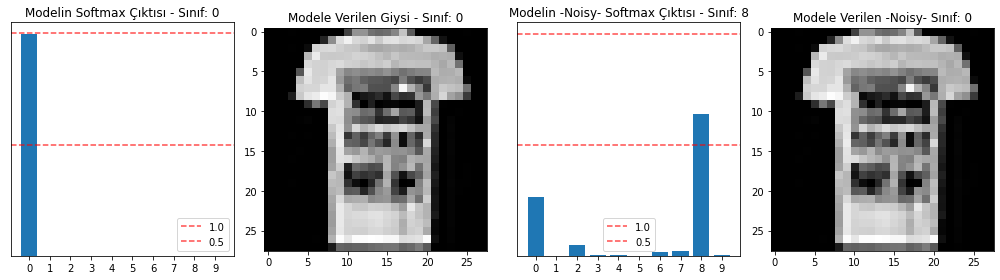

------------------------------------------------------------------------------------------------------------------------------------
Eklenen noise: 0.12944083403975104


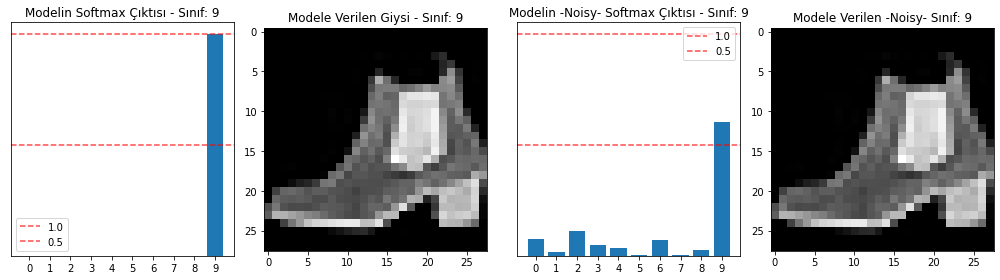

------------------------------------------------------------------------------------------------------------------------------------
Eklenen noise: 0.275791115688318


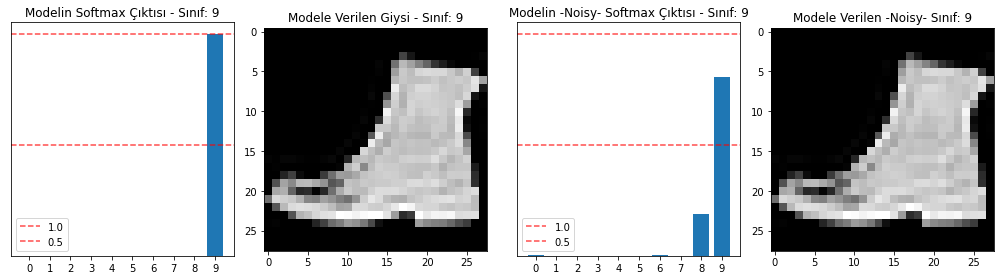

------------------------------------------------------------------------------------------------------------------------------------
Eklenen noise: -0.4949661603544896


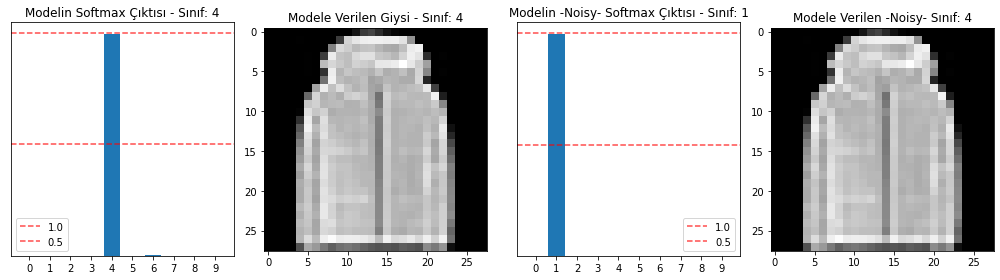

------------------------------------------------------------------------------------------------------------------------------------
Eklenen noise: 0.0614008612814109


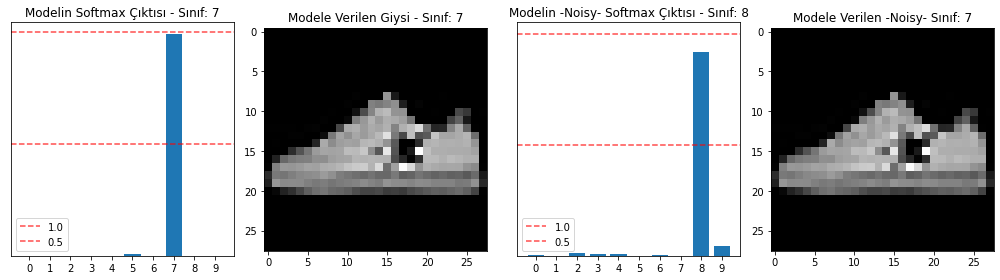

------------------------------------------------------------------------------------------------------------------------------------
Eklenen noise: 0.06706692199484897


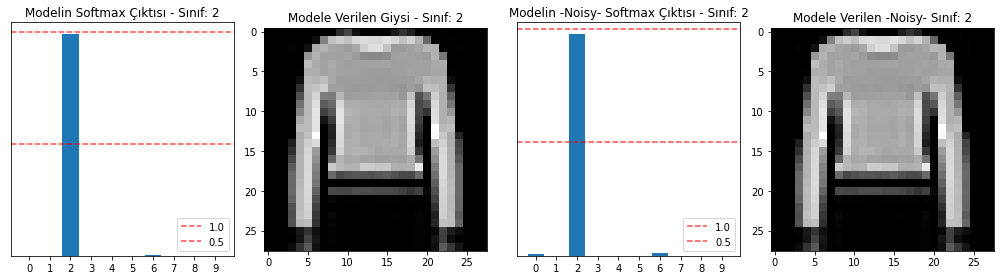

------------------------------------------------------------------------------------------------------------------------------------


In [9]:
for i in [0, 10, 20, 30, 40, 50]:
    predict_sample(samples[i], model, labels[i], add_noise = True, noise_std = 0.3)
    print('----' * 33)

### Resimlere Aynı Boyutta Noise Eklemek
* Resimleri biraz daha yok edelim.

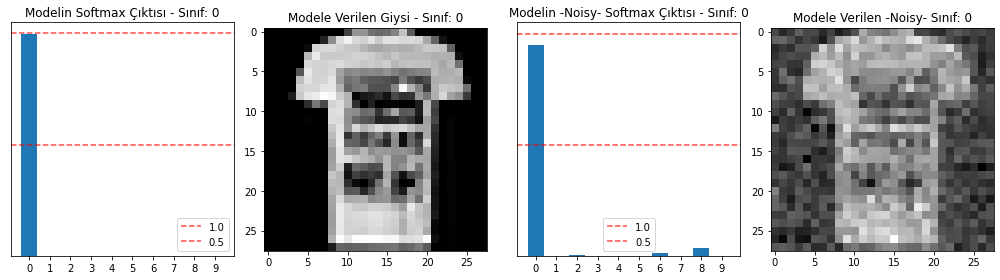

------------------------------------------------------------------------------------------------------------------------------------


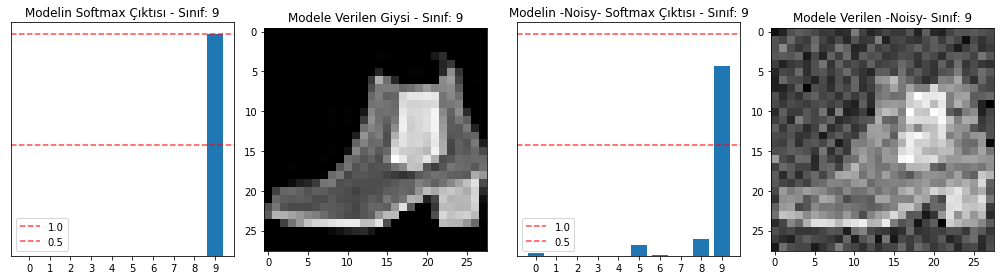

------------------------------------------------------------------------------------------------------------------------------------


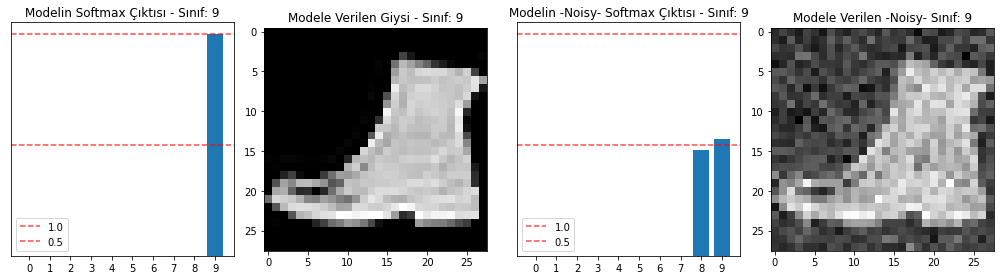

------------------------------------------------------------------------------------------------------------------------------------


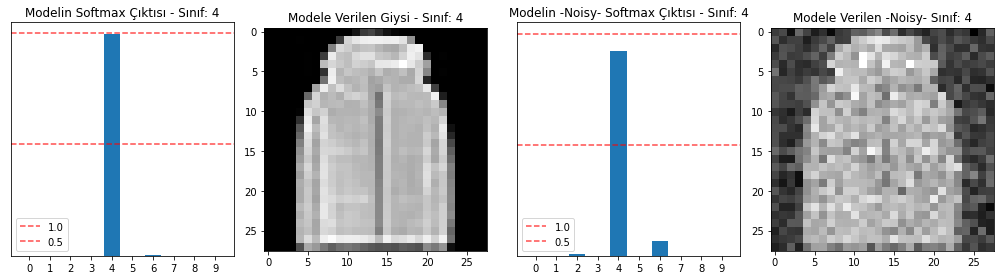

------------------------------------------------------------------------------------------------------------------------------------


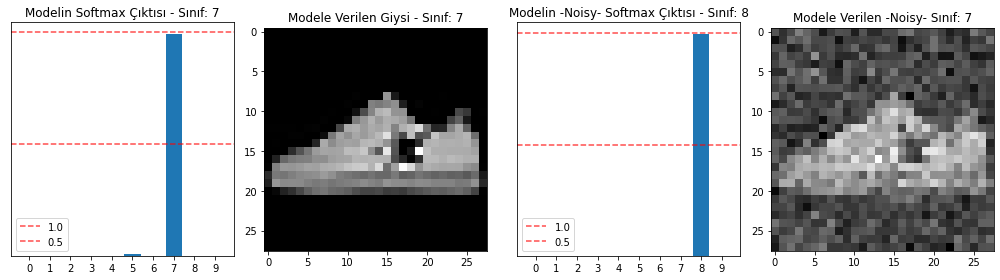

------------------------------------------------------------------------------------------------------------------------------------


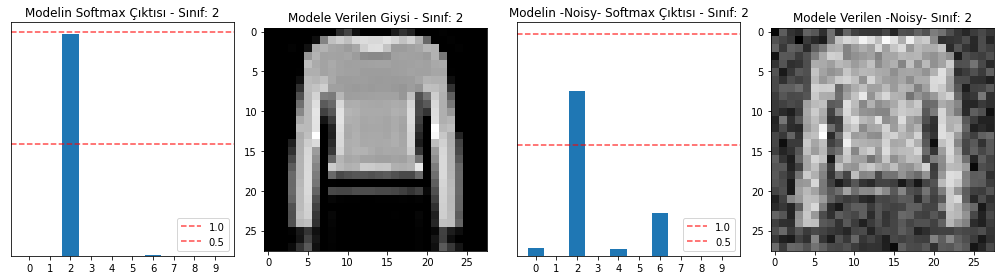

------------------------------------------------------------------------------------------------------------------------------------


In [10]:
for i in [0, 10, 20, 30, 40, 50]:
    predict_sample(samples[i], model, labels[i], add_all_img = True, noise_std = 0.15)
    print('----' * 33)

## Model Basit Olduğu İçin Şaşırdı Diyebilirsiniz..
O zaman devasa bir modelde deneyelim.

In [11]:
devasa_model = InceptionResNetV2(include_top = True, weights = 'imagenet')
print('Toplam Eğitilebilir Parametre Sayısı:', devasa_model.count_params())

Toplam Eğitilebilir Parametre Sayısı: 55873736


In [12]:
def get_prediction(devasa_model, image):
    plt.imshow(image / 255)
    processed = preprocess_input(image)
    
    # Resim shape = (299, 299, 3) -- > (1, 299, 299, 3)
    prediction = devasa_model.predict(tf.expand_dims(processed, axis = 0))
    
    # ImageNet tahminlerini decode_predictions() ile işleyebiliriz.
    prediction_details = decode_predictions(prediction)[0][0][1:3]
    plt.title('Tahmin: %s // Softmax Çıktısı: %.2f' % (prediction_details[0],
                                                           prediction_details[1]))

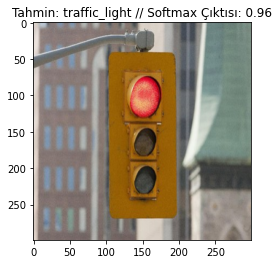

In [13]:
img_link = "https://smartcdn.prod.postmedia.digital/ottawacitizen/wp-content/uploads/2015/04/109960-ottawa-ont-aug-16-2012-stock-stock-photos-for-li.jpg?quality=90&strip=all&w=400"
image = tf.keras.utils.get_file(origin=img_link)
image = plt.imread(image)
image = cv2.resize(image, [299, 299])
image = image.astype(np.float32)
image_before = image.copy()

# Normal resimde prediction alalım.
get_prediction(devasa_model, image) # 0.96 --> traffic light

* Aşırı noise ekleyip deneyelim.

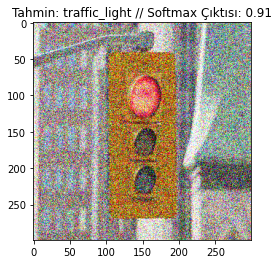

In [14]:
image_noisy = image_before + np.random.normal(loc = 20.9, scale = 65.2, size = (299, 299, 3))
get_prediction(devasa_model, image_noisy)

* Aslında iyi görünüyor, resmi yok edince bile doğru sınıfı bildi. (Siz bu hücreyi çalıştırınca sonuçlar farklı olabilir)

* O zaman olaya biraz daha matematiksel yaklaşalım :)

## Daha Karmaşık Örneğe Geçmeden Önce
<br>

### TensorFlow Gradient Tape
* `tf.GradientTape()` scope'u altında gradyan hesaplamaları yapabiliriz.

In [15]:
x = tf.constant(4.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.pow(x, 3) + x # x^3 + x
dy_dx = tape.gradient(y, x) # 3x^2 + 1 --> 3(4)^2 + 1
print(dy_dx) # 49.0

tf.Tensor(49.0, shape=(), dtype=float32)


`tf.keras.optimizers.Optimizer` sınıfının `apply_gradients` methodu bizim `GradientDescent` algoritmasını uygular.

Aşağıda vanilla SGD algoritmasını kullanıp, `apply_gradients()` methodunun aslında arkada nasıl çalıştığını görebilirsiniz. SGD kullanmamın sebebi, kolay takip edilebilir olmasıdır. Yoksa `Adam` vb gibi optimizerlarda bildiğimiz üzere hesaplamalar bu kadar basit değil.

In [16]:
learning_rate = 1
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
inputs = tf.Variable(tf.random.normal((1, 2)))
print("Array'in ilk hali:", inputs.numpy(), '\n')

for step in range(3):
    with tf.GradientTape() as tape:
        # inputs'u değiştireceğimiz için .watch() diyoruz.
        tape.watch(inputs)
        loss = tf.reduce_mean(inputs)
    print('Loss:', loss)    
    gradients = tape.gradient(loss, inputs) # gradyanları hesapladık
    print('Gradyanlar:', gradients)
    
    # W_new = W_i - learning_rate * gradients
    print('Elimizle Gradient Descent Uygularsak', inputs.numpy() - learning_rate * gradients.numpy())
    
    # Bunu apply_gradients ile yapabiliriz.
    opt.apply_gradients(zip([gradients], [inputs]))
    print('apply_gradients() Methodu ile:', inputs.numpy(), '\n')

Array'in ilk hali: [[-1.0259335 -0.3939535]] 

Loss: tf.Tensor(-0.70994353, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Elimizle Gradient Descent Uygularsak [[-1.5259335 -0.8939535]]
apply_gradients() Methodu ile: [[-1.5259335 -0.8939535]] 

Loss: tf.Tensor(-1.2099435, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Elimizle Gradient Descent Uygularsak [[-2.0259335 -1.3939536]]
apply_gradients() Methodu ile: [[-2.0259335 -1.3939536]] 

Loss: tf.Tensor(-1.7099435, shape=(), dtype=float32)
Gradyanlar: tf.Tensor([[0.5 0.5]], shape=(1, 2), dtype=float32)
Elimizle Gradient Descent Uygularsak [[-2.5259335 -1.8939536]]
apply_gradients() Methodu ile: [[-2.5259335 -1.8939536]] 



## Adversarial Attack
Modeli kandırmaya yönelik çalışmaların geneline `Adversarial Attack` diyebiliriz. Kasti bir vektör oluşturup, modelden bunu sınıflandırmasını isteyeceğiz.

Diğerlere nazaran karmaşık örneğe geçebiliriz.
* `nadam_opt`: Adam optimizer'ın bir türü olan ve Nesterov hızlandırması kullanan optimizerdır.
* `sparse_loss`: Model ImageNet üzerinde eğitildiği için 1000 sınıfı tanıyabiliyor. 
* `noise_vector`: Bu vektörü Gradient Descent ile değiştirip en son resme ekleyeceğiz.
* `min_max_clip`: -min_max_clip < noise_vector < min_max_clip, daha büyükler kırpılacak.
* `class_idx`: **traffic light** sınıfının ImageNet labellarında karşılığı 920.

Burada öyle bir `noise_vector` oluşturacağız ki, bu vektör resme eklendiği zaman `loss` değerini havaya uçuracak. Yani modelin yanlış sınıflandırma yapmasına neden olacak.

In [17]:
nadam_opt = tf.keras.optimizers.Nadam(0.1)
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy()
noise_vector = tf.Variable(tf.ones_like(image), trainable=True, dtype = tf.float32)
min_max_clip = 0.3
class_idx = 920

gradient_list = [] # Daha sonra incelemek isterseniz diye gradyanları listeye ekledim. 
                   # Fakat incelemek kadar detaya burada girmedim.

for step in range(0, 51):
    with tf.GradientTape() as tape:
        # Burada noise_vector'u değiştireceğimiz için .watch() diyerek takip ediyoruz.
        tape.watch(noise_vector)
        
        # Modelin yanlış sınıflandıracağı resmi adversarial_image olarak adlandırdık.
        # image_before da resmin orijinal halini içeriyor.
        adversarial_image = preprocess_input(image_before + noise_vector)
        
        # Batch dimension ekliyoruz. Yani shape = (299, 299, 3) --> (1, 299, 299, 3)
        adversarial_image = tf.expand_dims(adversarial_image, axis = 0)
        
        # Forward pass yapıp softmax çıktılarını alıyoruz.
        predictions = devasa_model(adversarial_image, training=False)
        
        # Loss hesaplıyoruz.
        # Soru: Neden - ile çarptık?
        # Cevap: Normal şartlar altında loss fonksiyonunu minimize etmeye çalışıyoruz.
        #       -1 ile çarptığımızda durum tersine dönüyor. Yani burada loss'u maksimize etmiş oluyoruz.
        # Yani biraz daha temele inmek isterseniz, yaptığımız şey iki dağılım arasındaki KL divergence'ı
        # maksimize etmek. Böylece loss'u maksimum hale getirecek bir noise vektörü bulabiliriz.
        loss = -sparse_loss(class_idx, predictions)
        
        # Her 10 adımda loss ve tahminin nasıl değiştiğini yazıyoruz.
        if step % 10 == 0:
            print('Tahmin Edilen Sınıf:', tf.argmax(predictions, axis = -1).numpy()[0],
                 'Gerçek Sınıf:', class_idx)
            print("Step: %d, Loss: %.3f" % (step, loss.numpy()), '\n')
        
        # Gradyanları hesaplayıp,
        grads = tape.gradient(loss, noise_vector)

        gradient_list.append(grads.numpy())
        
        # hesapladığımız gradyanları noise_vector'e uyguluyoruz. Bu durumda toplanmış oluyorlar,
        # çünkü yukarda loss'u (-) ile çarpmıştık. Gradient Ascent uygulamış olduk.
        nadam_opt.apply_gradients([(grads, noise_vector)],
                                  experimental_aggregate_gradients=True)
        
        # Noise_vector'u bu yeni değerlerle güncelliyoruz.
        noise_vector.assign_add(tf.clip_by_value(noise_vector, 
                                          clip_value_min=-min_max_clip,
                                          clip_value_max=min_max_clip))

Tahmin Edilen Sınıf: 920 Gerçek Sınıf: 920
Step: 0, Loss: -0.036 

Tahmin Edilen Sınıf: 920 Gerçek Sınıf: 920
Step: 10, Loss: -0.320 

Tahmin Edilen Sınıf: 790 Gerçek Sınıf: 920
Step: 20, Loss: -10.975 

Tahmin Edilen Sınıf: 790 Gerçek Sınıf: 920
Step: 30, Loss: -18.480 

Tahmin Edilen Sınıf: 790 Gerçek Sınıf: 920
Step: 40, Loss: -25.942 

Tahmin Edilen Sınıf: 790 Gerçek Sınıf: 920
Step: 50, Loss: -35.848 



Oluşturduğumuz vektörü görselleştireceğiz. Bize göre bu random bir vektör olarak görünse de, modelin tahminlerini saptıracak.

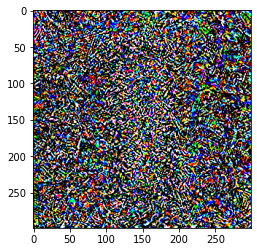

In [18]:
visualize = (noise_vector - tf.reduce_mean(noise_vector)) / tf.math.reduce_std(noise_vector)
visualize = tf.clip_by_value(visualize, 0, 255)
plt.imshow(visualize)

Oluşacak resim bizim gözümüze aynı görünecek fakat model için çok şey değişmiş olacak.

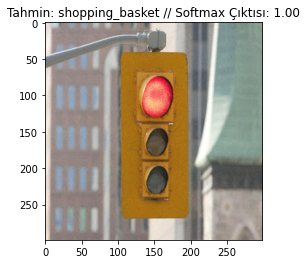

In [19]:
# Oluşturduğumuz vektörü orijinal resme ekliyoruz.
updated_image = image_before + noise_vector
updated_image = np.clip(updated_image, 0, 255).astype("uint8")

# Ve tahmin alınca çıktı --> shopping_basket: 1.0 :))
get_prediction(devasa_model, updated_image)